# Exercise 08
## Lars Kühmichel, Nicolas Wolf

In [261]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [262]:
plt.rc("figure", dpi=150)
plt.rc("legend", fontsize=6)

## Task 1: Discrete-time non-linear dynamics: fixed points and stability

In [263]:
def f(x, a, b):
    return a * x + b * np.tanh(x)

### 1. Plot the return plot of this map for the given parameter sets.

In [264]:
def time_series(f, x0, steps, *args, **kwargs):
    x = [x0]
    for _ in range(steps):
        xt = f(x[-1], *args, **kwargs)
        x.append(xt)

    return np.array(x)

In [265]:
params = [
    dict(a=1.0, b=3.0),
    dict(a=0.5, b=-2.0),
    dict(a=0.5, b=3.0),
    dict(a=1.0, b=0.0),
]

x0 = 1.0
steps = 100

data = {}

for p in params:
    a, b = p.values()
    title = f"{a:.1f}, {b:.1f}"

    data[title] = time_series(f, x0, steps, **p)

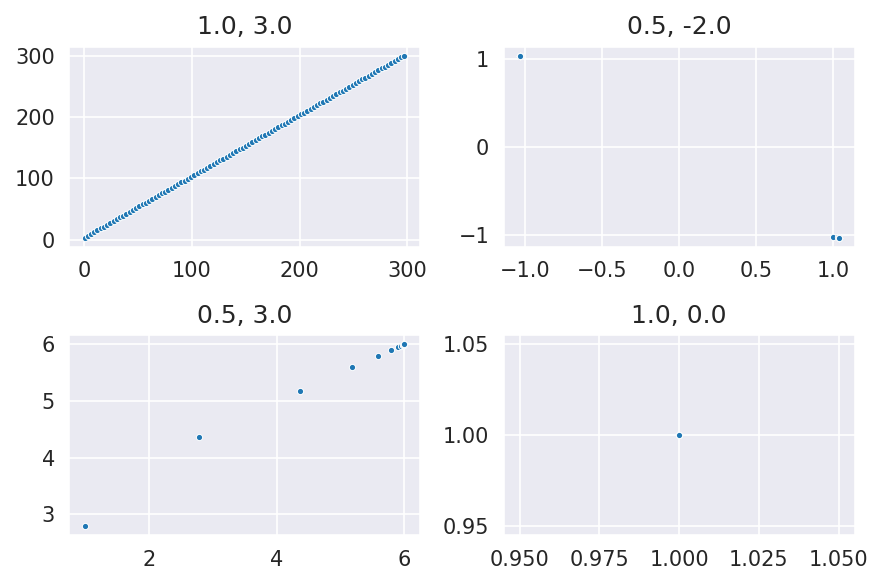

In [266]:
for i, (title, x) in enumerate(data.items()):
    plt.subplot(2, 2, i + 1)
    sns.scatterplot(x=x[:-1], y=x[1:], marker=".")
    plt.title(title)

plt.tight_layout()

### By inspecting the plot, how many fixed points do you expect the system to have?

Each of these series has the trivial fixed point $x = 0$, which does not depend on $a, b$. We will not mention this trivial solution again.

For $a = 0.5$, we can expect $2$ fixed points. For $a = 1, b = 0$, we can expect a single fixed point. $a = 1, b = 3$ seems to diverge, i.e. no fixed points.

### Comment on their stability.

The fixed points for $a = 0.5, b = 3$ seem unstable (oscillating). As such they would not be true "fixed points" that solve $f(x) = x$. The others seem to be stable.

In [267]:
x0s = [-10.0, -0.5, 0.5, 10.0]

data = {}

for x0 in x0s:
    for p in params:
        a, b = p.values()
        title = f"{x0:.1f}, {a:.1f}, {b:.1f}"

        data[title] = time_series(f, x0, steps, **p)

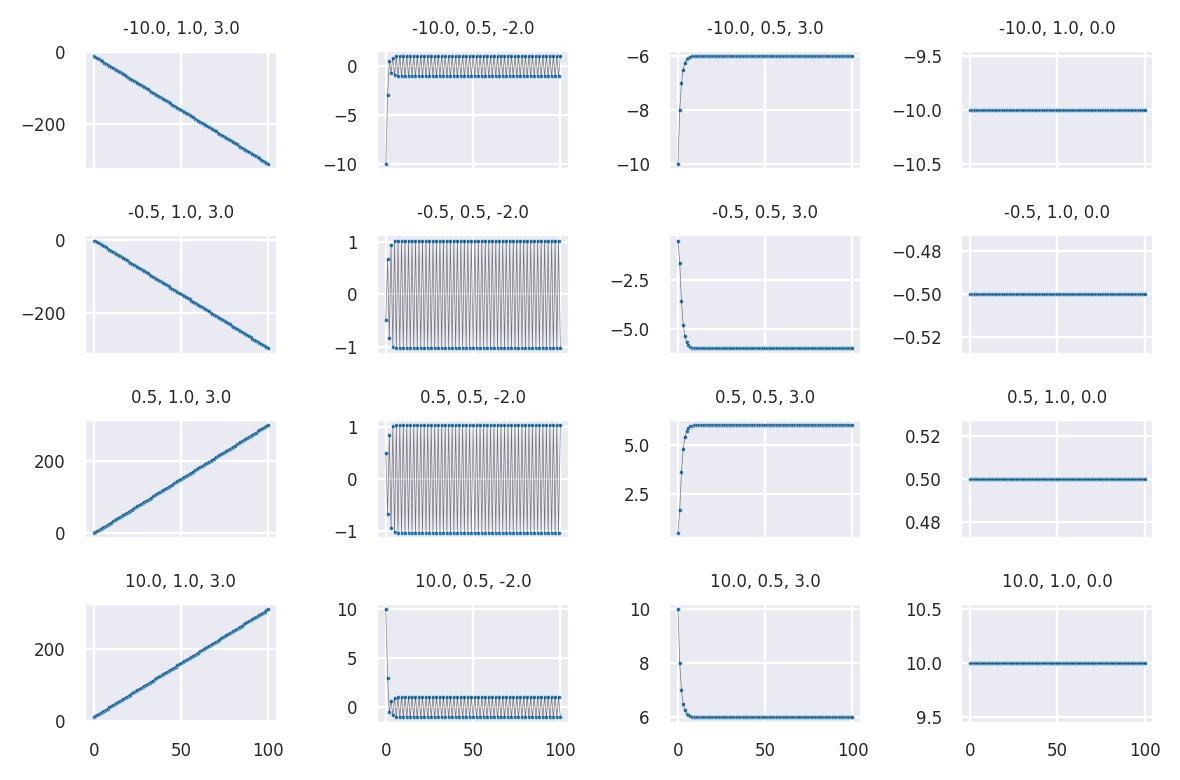

In [268]:
nrows = int(np.ceil(np.sqrt(len(data))))
ncols = int(np.ceil(len(data) / nrows))

plt.subplots(nrows, ncols, sharex="all", dpi=200)

for i, (title, x) in enumerate(data.items()):
    plt.subplot(nrows, ncols, i + 1)
    sns.scatterplot(data=x, s=2.0)
    sns.lineplot(data=x, linewidth=0.25, alpha=0.5, color="black")
    plt.title(title, dict(fontsize=6))
    ax = plt.gca()
    ax.xaxis.set_tick_params(labelsize=6)
    ax.yaxis.set_tick_params(labelsize=6)

plt.tight_layout()

We were partially right. $a = 1, b = 3$ diverges in all cases. $a = 0.5, b = -2$ always has two oscillating fixed points around $x \in \{-1, 1\}$.  $a = 0.5, b = 3$ has two fixed points, but only one is reached, depending on $x_0$. $a = 1, b = 0$ does not vary at all. All fixed points are stable.

### 3. Confirm your intuitions by computing the fixed points numerically, and their stability analytically.

In [269]:
# use parameter set III
a = 0.5
b = 3

In [270]:
import scipy.optimize as optimize
import scipy.signal as signal


def get_fixed_points(f, xmin, xmax, max_points=1000, tol=None, args=()):
    """ Find all fixed points f(x) = x in the interval [xmin, xmax] by iteration """
    if tol is None:
        # auto-determine tolerance
        tol = (xmax - xmin) / max_points

    fixed_points = []
    x0s = np.linspace(xmin, xmax, max_points)

    for x0 in x0s:
        fp, info, ier, msg = optimize.fsolve(lambda x: f(x, *args) - x, x0=x0, full_output=True)
        if ier == 1:
            # found a solution
            fixed_points.append(fp)

    fixed_points = np.squeeze(fixed_points)

    fixed_points, mult = signal.unique_roots(fixed_points, tol=tol)

    return fixed_points

In [271]:
fixed_points = get_fixed_points(f, -10, 10, args=(a, b))

fixed_points

array([-5.99992626,  5.99992626,  0.        ])

We find that $f(x, a=0.5, b=3)$ has 2 non-trivial fixed points, as previously suggested.

For this parameter set, we have

$$
f' = \frac{df}{dx} = 3 \operatorname{sech}^2(x) + 0.5
$$

A fixed point $x_f$ is stable, if $\vert f'(x_f) \vert < 1$. Here, we have $f'(-6) = f'(6) \approx 0.5$, so both fixed points are stable.